
# Implicit Euler method

The **forward Euler** (explicit) step:

$$
x_{n+1}=x_n + \Delta t\big(p - r x_n^\lambda\big).
$$

That *is* the obvious starting point. The next steps are to decide whether it’s acceptable for your model (accuracy, stability, nonnegativity) and — if not — pick a small change that fixes the problem while keeping the update cheap for many cells. Below I give practical guidance, stability advice, and several ready-to-use update rules (explicit Euler, stabilized/implicit Euler, and the very cheap exact implicit step for $\lambda=\tfrac12$). Use whichever fits your needs.

---

## 1 — When explicit Euler is OK

Forward Euler is fine if:

* your timestep $\Delta t$ is **small compared to the inverse local slope**,
* you accept **first-order** accuracy,
* and you ensure the solution stays positive.

Rough stability condition (linearizing $f(x)=p-rx^\lambda$ about $x$):

$$
f'(x) = -r\lambda x^{\lambda-1},\qquad
\text{so require }\; \Delta t \cdot |f'(x)| \lesssim C,
$$

with $C$ a small method-dependent constant (e.g. for Euler roughly $C\approx 1$). Thus

$$
\Delta t \lesssim \frac{1}{r\lambda} x^{\,1-\lambda}.
$$

If $x$ can become small this bound tightens drastically for $0<\lambda<1$. So in many models explicit Euler forces impractically small $\Delta t$.

---

## 2 — Ensure non-negativity

Forward Euler can produce negative $x_{n+1}$ when $p$ is small or zero and $\Delta t$ large. Always enforce physical bounds:

```python
x_np1 = x_n + dt*(p - r * x_n**lam)
x_np1 = max(x_np1, 0.0)
```

But clipping hides instability and can reduce accuracy — better to use an implicit stable method.



## 3 — Cheap stable alternative: **implicit Euler** (scalar problem)

Implicit Euler is A-stable and cheap for a scalar update — you solve

$$
x_{n+1} = x_n + \Delta t\big(p - r x_{n+1}^\lambda\big).
$$

This requires solving a single scalar nonlinear equation per cell. Use Newton (1–3 iterations usually) — very cheap.

General Newton implementation:

```python
def implicit_euler_step(xn, dt, p, r, lam, tol=1e-12, maxit=10):
    # Solve G(x) = x - xn - dt*(p - r*x**lam) = 0
    x = xn  # initial guess
    for _ in range(maxit):
        G = x - xn - dt*(p - r * x**lam)
        if abs(G) < tol:
            break
        Gp = 1 + dt * r * lam * x**(lam - 1)   # derivative of G
        dx = - G / Gp
        x += dx
        if abs(dx) < tol:
            break
    return max(x, 0.0)
```

This is robust even when $\lambda<1$ and $x$ small, because the method is implicit.

## 4 — If $\lambda=\tfrac12$: **closed-form implicit step** (very cheap!)

Let $u=\sqrt{x}$. With implicit Euler you get a quadratic in $u_{n+1}$ that you can solve exactly — **no Newton**:

From

$$
u_{n+1}^2 = u_n^2 + \Delta t\big(p - r u_{n+1}\big),
$$

rearrange:

$$
u_{n+1}^2 + (\Delta t\,r) u_{n+1} - \big(u_n^2 + \Delta t\,p\big)=0.
$$

Positive root:

$$
u_{n+1} = \frac{-\Delta t\,r + \sqrt{(\Delta t\,r)^2 + 4\big(u_n^2 + \Delta t\,p\big)}}{2},
\quad x_{n+1}=u_{n+1}^2.
$$

```python
def implicit_euler_step_lambda_half(xn, dt, p, r):
    u_n = math.sqrt(xn)
    A = u_n*u_n + dt * p
    disc = (dt*r)**2 + 4.0 * A
    u_np1 = (-dt*r + math.sqrt(disc)) / 2.0
    return u_np1 * u_np1
```

This is ideal if $\lambda=0.5$: extremely cheap, unconditionally stable, preserves nonnegativity.

## 5 — Midpoint (RK2) or trapezoidal (Crank-Nicolson)
- Explicit RK2 (midpoint) raises the stability requirement vs Euler but is still explicit — therefore problematic near small x.
- Implicit midpoint (second-order, A-stable) or Crank–Nicolson are options if you need higher order; they require a scalar nonlinear solve per step (Newton) — still cheap for per-cell updates.



## 6 — Implementation strategy for a model called every timestep
- If \(\lambda=0.5\): use the closed-form implicit step per cell (section 4). Use this as your default — it’s fast and stable.
- If \(\lambda\) varies or is general but scalar: use implicit Euler with 1–3 Newton iterations initialized at \(x_n\). That’s cheap and robust.
- Only use explicit Euler or RK2 if you can guarantee timestep satisfies the stability bound for all cells.
- Vectorize updates across cells if using numpy: the implicit Newton loop can still be vectorized with element-wise operations or applied per-cell in a compiled loop (Cython / numba) for speed.


## 7 — Example combined code
```python
import math, numpy as np

def forward_euler_step(xn, dt, p, r, lam):
    x_np1 = xn + dt*(p - r * xn**lam)
    return np.maximum(x_np1, 0.0)

def implicit_euler_step_lambda_half(xn, dt, p, r):
    # supports arrays
    u_n = np.sqrt(xn)
    A = u_n*u_n + dt * p
    disc = (dt*r)**2 + 4.0 * A
    u_np1 = (-dt*r + np.sqrt(disc)) / 2.0
    return np.maximum(u_np1 * u_np1, 0.0)

def implicit_euler_step_newton(xn, dt, p, r, lam, tol=1e-10, maxit=10):
    # vectorized Newton, careful with zeros/small values
    x = xn.copy()
    for _ in range(maxit):
        G = x - xn - dt*(p - r * x**lam)
        if np.all(np.abs(G) < tol):
            break
        Gp = 1 + dt * r * lam * np.where(x>0, x**(lam-1), np.inf)
        dx = - G / Gp
        x = x + dx
        x = np.maximum(x, 0.0)
    return x
```



## 8 — Accuracy notes
- Implicit Euler: first-order accurate (error \(O(\Delta t)\)). Good stability.
- Implicit midpoint / Crank–Nicolson: second order, but require solving non-linear equation too.
- If you need higher order cheaply, consider performing Richardson/extrapolation: take two implicit Euler half-steps and combine to get a second-order result.

---

## 9 — Quick decision guide
- **Use closed-form implicit** if \(\lambda=0.5\) — fastest & safest.
- **Use implicit Euler (Newton)** if \(\lambda\) general — stable & cheap (scalar).
- **Use explicit Euler / RK2** only when timestep small enough uniformly across all cells.

---

If you want, I can:
- give a **vectorized numba** implementation for high performance across many cells, or  
- produce a tiny benchmark comparing explicit Euler, RK2, implicit Euler (Newton), and the closed-form \(\lambda=0.5\) step (accuracy vs. CPU time) so you can pick the fastest acceptable method.

Which of those would help most?
$$


# Example

Three methods to compute x(t) given
x = S/Smax (Smax of root zone)
p = P / Smax
e = E / Smax

/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_64676/4075769402.py:16: RuntimeWarning: divide by zero encountered in scalar power
  df = 1 - dt * (-r * lam * x**(lam-1))


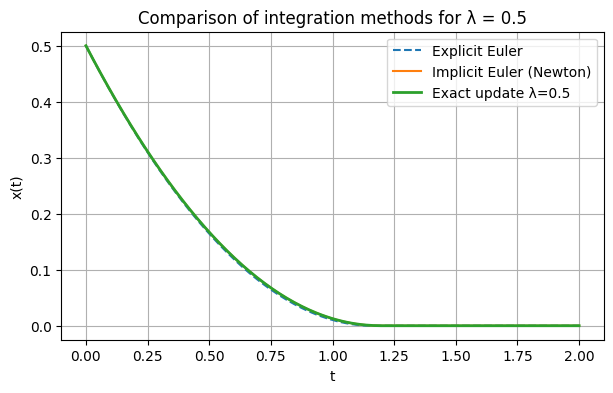

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- exact update for lambda = 0.5 ---
def implicit_euler_step_lambda_half(x0, dt, p, r):
    """Implicit for lambda = 0.5. Extremely cheap!"""
    u_n = np.sqrt(x0)
    D = (r * dt) ** 2 + 4.0 * (u_n ** 2 + p * dt)
    u_np1 = (-r * dt + np.sqrt(D)) / 2.0
    return np.maximum(u_np1 ** 2, 0.0)

# --- implicit Euler step (general λ) ---
def implicit_euler_step(x0, dt, p, r, lam, maxiter=20, tol=1e-12):
    """Works for any lambda > 0"""
    x = x0
    for _ in range(maxiter):
        f = x - x0 - dt * (p - r * x**lam)
        df = 1 - dt * (-r * lam * x**(lam-1))
        dx = -f / df
        x = np.maximum(x + dx, 0.0)
        if np.all(np.abs(dx) < tol):
            break
    return x

# --- explicit Euler step ---
def explicit_euler_step(x0, dt, p, r, lam):
    """Also works for any lambda > 0 but requires small time steps."""
    return np.maximum(x0 + dt * (p - r * x0**lam), 0.0)

# --- simulation loop ---
def simulate(method, t, x0, p, r, lam):
    """Simulation is done one timestep at a time."""
    x = np.zeros_like(t)
    x[0] = x0
    for i in range(1, len(t)):
        x[i] = method(x[i-1], t[i]-t[i-1], p, r, lam)
    return x

# %%
# parameters
x0 = 0.5
p, r, lam = 0.0, 1.2, 0.5
t = np.linspace(0, 2, 200)

# simulate
x_exp = simulate(lambda x,dt,p,r,lam: explicit_euler_step(x,dt,p,r,lam), t, x0, p, r, lam)
x_imp = simulate(lambda x,dt,p,r,lam: implicit_euler_step(x,dt,p,r,lam), t, x0, p, r, lam)
x_exa = simulate(lambda x,dt,p,r,lam: implicit_euler_step_lambda_half(x,dt,p,r), t, x0, p, r, lam)

# %%
# plot
plt.figure(figsize=(7,4))
plt.plot(t, x_exp, label="Explicit Euler", ls="--")
plt.plot(t, x_imp, label="Implicit Euler (Newton)")
plt.plot(t, x_exa, label="Implicit for λ=0.5", lw=2)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Comparison of integration methods for λ = 0.5")
plt.grid(True)
plt.legend()
plt.show()

# We need the time when the reservoir is exactly full, because then it flows over.

The code for lambda = 0.5 is below.

In [ ]:
import numpy as np
import math

def S_rootzone(P, E, Dt):
    # implicit_euler_step_lambda_half(xn, dt, p, r):
    """Return S extimate
    
    I'm not sure whether this is correct  because the function
    is not linear and should therefore be solved by stepwise
    integration or an analytical solution
    """
    maxit, tol = 20, 1e-6
    S0, Smax = 20., 100.,
    p, r, x0 = P / Smax, E / Smax, S0 / Smax

    unp1 = np.sqrt(x0)
    for i in range(maxit):
        un = unp1            
        D = (Dt * r) ** 2 + 4.0 * (un ** 2 + Dt * p)
        unp1 = (-Dt * r + math.sqrt(D)) / 2.0
        if math.abs(unp1 - un) < tol:
            break
    if i >= maxit:
        raise ValueError(f"Convergence fails in {i} iterations.")            
    return unp1 ** 2


def dt_hit_root_zone(P: float, E: float, Dt: float)->float:
    # def hitting_time_to_one(x0, p, r, Dt=0.0):
    """
    Computation of t_hit such that x(t_hit) = 1 for
    dx/dt = p - r * sqrt(x), using the exact integrated formula
    in u = sqrt(x). Returns np.inf when the level 1 is not reached
    in finite time.
    
    Inputs are scalars.
    """
    S0, Smax = 20., 100.
    p, r, x0 = P / Smax, E / Smax, S0 / Smax
    t0 = 0
    
    u0 = np.sqrt(max(x0, 0.0))
    us = p / r   # steady-state y* = p/r because x* = (p/r) ** 2
    
    # Prepare output
    
    # Case: already at or above 1
    if x0 > 1:    
        t_hit = t0
    else:
    
        # Determine x can cross 1 in finite time:
        can_cross = ( (u0 - 1.0) * (us - 1.0) ) < 0.0
    
        # Compute t_hit for those
        if can_cross:
            # compute formula
            term1 = (2.0 / r) * (u0 - 1.0)
            term2 = (2.0 * p) / (r**2) * np.log( (p - r * u0) / (p - r) )
            t_hit = t0 + term1 + term2
    
    return t_hit


In [ ]:
import numpy as np

def hitting_time_to_one(x0, p, r, t0=0.0):
    """
    Vectorized computation of t_hit such that x(t_hit) = 1 for
    dx/dt = p - r * sqrt(x), using the exact integrated formula
    in y = sqrt(x). Returns np.inf where the level 1 is not reached
    in finite time.
    
    Inputs can be scalars or numpy arrays (broadcastable).
    """
    x0 = np.asarray(np.atleast_1d(x0), dtype=float)
    p  = np.asarray(np.atleast_1d(p ), dtype=float)
    r  = np.asarray(np.atleast_1d(r ), dtype=float)
    
    # Broadcast shapes
    shape = np.broadcast(x0, p, r).shape
    x0_b = np.broadcast_to(x0, shape).astype(float)
    p_b  = np.broadcast_to(p,  shape).astype(float)
    r_b  = np.broadcast_to(r,  shape).astype(float)
    
    y0 = np.sqrt(np.maximum(x0_b, 0.0))
    ust = p_b / r_b           # steady-state y* = p/r because x* = (p/r) ** 2
    
    # Prepare output
    t_hit = np.full(shape, np.inf, dtype=float)
    
    # Case: already at or above 1
    already = (x0_b >= 1.0)
    t_hit[already] = t0
    
    # Determine which entries can cross 1 in finite time:
    can_cross = ( (y0 - 1.0) * (ust - 1.0) ) < 0.0
    
    # Compute t_hit for those
    idx = np.where(can_cross)
    if idx[0].size > 0 or len(idx) == 1:
        y0_sel = y0[idx]
        p_sel  = p_b[idx]
        r_sel  = r_b[idx]
        # compute formula
        term1 = (2.0 / r_sel) * (y0_sel - 1.0)
        term2 = (2.0 * p_sel) / (r_sel**2) * np.log( (p_sel - r_sel * y0_sel) / (p_sel - r_sel) )
        t_hit[idx] = t0 + term1 + term2
    
    return t_hit


In [9]:
# single case
x0 = 0.25
p, r = 1.5, 1.0

print(hitting_time_to_one(x0, p, r))   # finite time because p/r = 1.5 > 1 and x0 < 1

# vectorized
x0 = np.array([0.2, 0.8, 1.2, 0.6])
p, r = 0.9, 1.0   # steady < 1

print(hitting_time_to_one(x0, p, r))   # some entries inf, some finite depending on sign


[1.07944154]
[       inf        inf 1.39708717        inf]
